In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pytransit import QuadraticModel
from scipy.signal import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, BatchNormalization, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import lightkurve as lk
import tensorflow as tf
from tensorflow.keras import backend as K
from imblearn.over_sampling import SMOTE

In [70]:
np.random.seed(42)
tf.random.set_seed(42)

DATA_FILE_SYNTH = "transit_dataset.npz"
DOWNSAMPLE_SIZE = 2000

epochs = 100
batch_size = 64

In [71]:
def normalize_data(data):
    mean_flux = np.mean(data, axis=1, keepdims=True)
    std_flux = np.std(data, axis=1, keepdims=True)
    return (data - mean_flux) / std_flux

def augment_data(flux):
    if np.random.rand() > 0.5:
        flux += np.random.normal(0, 0.0002, size=flux.shape)
    if np.random.rand() > 0.5:
        shift = np.random.randint(-5, 5)
        flux = np.roll(flux, shift)
    if np.random.rand() > 0.5:
        stretch = np.random.uniform(0.8, 1.2)
        flux = np.interp(np.linspace(0, len(flux), int(len(flux) * stretch)), np.arange(len(flux)), flux)
    return flux

In [72]:
def generate_synthetic_data(num_transits=500, num_non_transits=5000, time_range=27, cadence=30, noise_level=0.0005, stellar_var_amp=0.0002):
    times = np.linspace(0, time_range, int(time_range * 24 * 60 / cadence))
    synthetic_data, labels = [], []

    for _ in range(num_transits + num_non_transits):
        has_transit = len(synthetic_data) < num_transits
        flux = np.ones_like(times)

        if has_transit:
            k = np.random.uniform(0.05, 0.15)
            p = np.random.uniform(2, 10)
            a = np.random.uniform(5, 20)
            i_rad = np.random.uniform(85, 90) * np.pi / 180
            e, w = 0.0, 90.0
            ldc = [np.random.uniform(0.2, 0.6), np.random.uniform(0.1, 0.4)]
            tm = QuadraticModel()
            tm.set_data(times)
            flux = tm.evaluate(k=k, t0=0.0, p=p, a=a, i=i_rad, e=e, w=w, ldc=ldc)

        variability = np.random.uniform(0, stellar_var_amp) * np.sin(2 * np.pi * times / np.random.uniform(5, 20))
        flux += variability + np.random.normal(0, noise_level, size=times.shape)

        flux = augment_data(flux)
        synthetic_data.append(resample(flux, DOWNSAMPLE_SIZE))
        labels.append(1 if has_transit else 0)

    return np.array(synthetic_data), np.array(labels)

In [73]:
def fetch_observational_data(num_samples=500, downsample_size=2000):
    """Fetch real Kepler data with realistic transit ratio (1% transit, 99% non-transit)."""
    transit_ids = ["Kepler-10", "Kepler-20", "Kepler-22", "Kepler-90"]
    no_transit_ids = ["KIC 8462852", "KIC 3542116", "KIC 2856960", "KIC 6034120"]

    obs_data, obs_labels = [], []

    for target in transit_ids:
        try:
            search = lk.search_lightcurve(target, mission="Kepler")
            if search:
                lc_collection = search.download_all()
                for lc in lc_collection[:int(num_samples * 0.1)]:
                    flux = lc.flux.value
                    flux = flux[np.isfinite(flux)]
                    if len(flux) > 100:
                        obs_data.append(resample(flux, downsample_size))
                        obs_labels.append(1)
        except Exception as e:
            print(f"Error fetching {target}: {e}")

    for target in no_transit_ids:
        try:
            search = lk.search_lightcurve(target, mission="Kepler")
            if search:
                lc_collection = search.download_all()
                for lc in lc_collection[:int(num_samples * 0.90)]:
                    flux = lc.flux.value
                    flux = flux[np.isfinite(flux)]
                    if len(flux) > 100:
                        obs_data.append(resample(flux, downsample_size))
                        obs_labels.append(0)
        except Exception as e:
            print(f"Error fetching {target}: {e}")

    return np.array(obs_data), np.array(obs_labels)

In [74]:
def build_model(input_shape):
    model = Sequential([
        Conv1D(128, kernel_size=5, activation='swish', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),

        Conv1D(256, kernel_size=5, activation='swish'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.4),

        LSTM(128, return_sequences=True),
        LSTM(128),

        Dense(256, activation='swish'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    def focal_loss(alpha=0.25, gamma=2.0):
        def loss(y_true, y_pred):
            y_pred = K.clip(y_pred, 1e-7, 1.0 - 1e-7)
            pt = y_true * y_pred + (1 - y_true) * (1 - y_pred)
            loss = -alpha * (1 - pt) ** gamma * K.log(pt)
            return K.mean(loss)
        return loss

    optimizer = Adam(learning_rate=0.0001)
    # model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    model.compile(optimizer, loss=focal_loss(), metrics=['accuracy', tf.keras.metrics.AUC()])
    model.summary()
    
    return model

In [75]:
def plot_training(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Val Loss')
    axs[0].set_title("Loss Trend")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    axs[1].plot(history.history['accuracy'], label='Train Accuracy')
    axs[1].plot(history.history['val_accuracy'], label='Val Accuracy')
    axs[1].set_title("Accuracy Trend")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.show()

In [76]:
def plot_roc_pr(y_test, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    precisions, recalls, _ = precision_recall_curve(y_test, y_pred_prob)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # roc curve
    axs[0].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    axs[0].plot([0, 1], [0, 1], 'k--')
    axs[0].set_title("ROC Curve")
    axs[0].set_xlabel("False Positive Rate")
    axs[0].set_ylabel("True Positive Rate")
    axs[0].legend()

    # precision-recall curve
    axs[1].plot(recalls, precisions)
    axs[1].set_title("Precision-Recall Curve")
    axs[1].set_xlabel("Recall")
    axs[1].set_ylabel("Precision")

    plt.show()

In [77]:
def train_and_evaluate(X_train, X_test, y_train, y_test):
    model = build_model((X_train.shape[1], 1))
    
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stop, lr_scheduler],
                        verbose=1)

    plot_training(history)

    y_pred_prob = model.predict(X_test, verbose=0).flatten()
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)
    epsilon = 1e-10
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + epsilon)
    best_threshold = thresholds[np.argmax(f1_scores)] if len(thresholds) > 0 else 0.5
    y_pred = (y_pred_prob > best_threshold).astype(int)

    print(f"\nBest Decision Threshold: {best_threshold:.3f}")
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Transit", "Transit"], yticklabels=["No Transit", "Transit"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    plot_roc_pr(y_test, y_pred_prob)

    report = classification_report(y_test, y_pred, target_names=["No Transit", "Transit"])
    print("Classification Report:\n", report)

    return model

In [78]:
def main():

    DATA_FILE = "transit_dataset.npz"

    if os.path.exists(DATA_FILE):
        print("Loading saved dataset...")
        data = np.load(DATA_FILE)
        X_synth, y_synth = data["X_synth"], data["y_synth"]
        X_obs, y_obs = data["X_obs"], data["y_obs"]
    else:
        print("Generating synthetic dataset...")
        X_synth, y_synth = generate_synthetic_data()
        print("Fetching observational dataset...")
        X_obs, y_obs = fetch_observational_data()
        np.savez(DATA_FILE, X_synth=X_synth, y_synth=y_synth, X_obs=X_obs, y_obs=y_obs)
        print("Dataset saved to", DATA_FILE)

    X_data = np.concatenate((X_synth, X_obs))
    y_data = np.concatenate((y_synth, y_obs))

    X_data = normalize_data(X_data)

    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

    # SMOTE is applied since the dataset is skewed
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train)

    X_train_resampled = X_train_resampled.reshape(-1, X_train.shape[1], 1)  

    print("Before SMOTE:", X_train.shape, y_train.shape)
    print("After SMOTE:", X_train_resampled.shape, y_train_resampled.shape)

    model = train_and_evaluate(X_train_resampled, X_test[..., np.newaxis], y_train_resampled, y_test)
    model.save('transit_classifier.keras')
    print("Model saved successfully!")

Generating synthetic dataset...
Fetching observational dataset...


Error fetching Kepler-22: Error in reading Data product /Users/Arnav/.lightkurve/cache/mastDownload/Kepler/kplr010593626_sc_Q001333333303333332/kplr010593626-2011334093404_slc.fits of type KeplerLightCurve .
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.
Dataset saved to transit_dataset.npz
Before SMOTE: (4569, 2000) (4569,)
After SMOTE: (8124, 2000, 1) (8124,)


/Users/Arnav/Documents/EXXA-Evaluation-Test/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 1996, 128)      │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1996, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 998, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 998, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 994, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 994, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 497, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 497, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 497, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 528,385 (2.02 MB)

 Trainable params: 527,617 (2.01 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 52s 368ms/step - accuracy: 0.8304 - auc_2: 0.9006 - loss: 0.0238 - val_accuracy: 0.1111 - val_auc_2: 0.6150 - val_loss: 0.3276 - learning_rate: 1.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 337ms/step - accuracy: 0.9670 - auc_2: 0.9823 - loss: 0.0089 - val_accuracy: 0.1111 - val_auc_2: 0.4519 - val_loss: 0.2884 - learning_rate: 1.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 341ms/step - accuracy: 0.9712 - auc_2: 0.9811 - loss: 0.0086 - val_accuracy: 0.1111 - val_auc_2: 0.5108 - val_loss: 0.3414 - learning_rate: 1.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 45s 349ms/step - accuracy: 0.9728 - auc_2: 0.9833 - loss: 0.0078 - val_accuracy: 0.1155 - val_auc_2: 0.8264 - val_loss: 0.2372 - learning_rate: 1.0000e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 47s 369ms/step - accuracy: 0.9684 - auc_2: 0.9841 - loss: 0.0080 - val_accuracy: 0.9571 - val_auc_2: 0.9201 - val_loss: 0.0134 - learning_rate: 1.0000e-04
Epoch 6/50
127/127 ━━━━━━

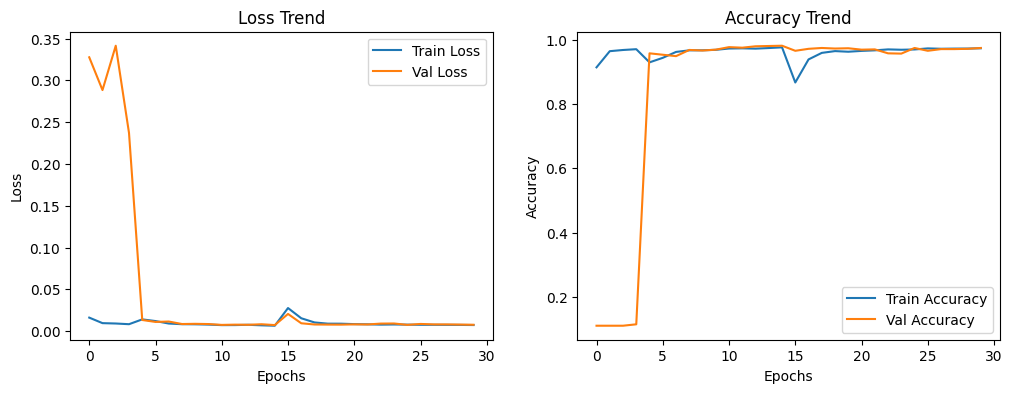


Best Decision Threshold: 0.653
F1 Score: 0.9198


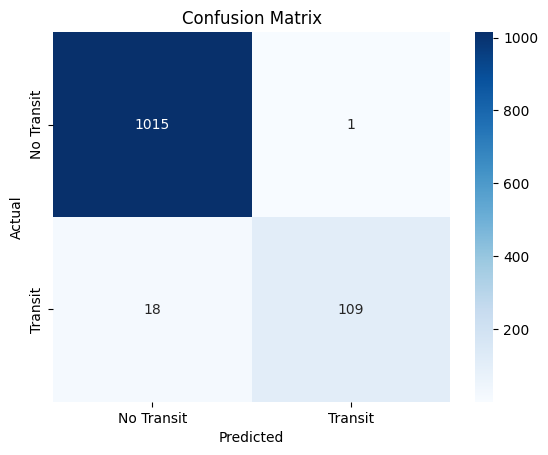

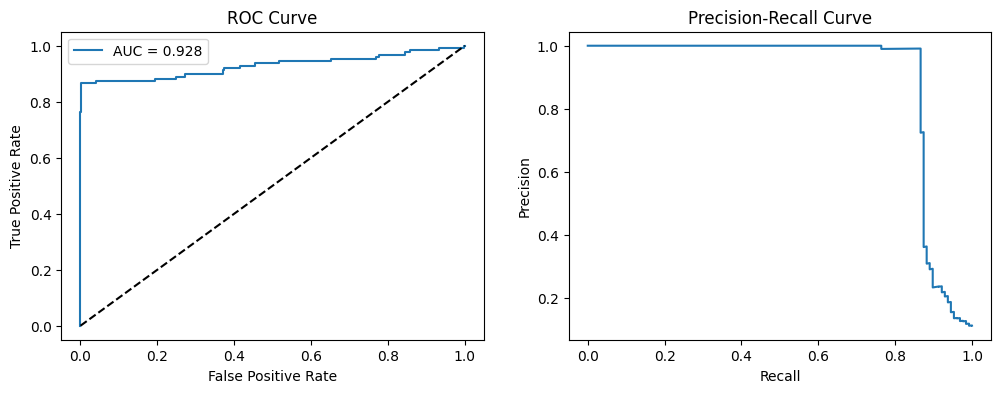

Classification Report:
               precision    recall  f1-score   support

  No Transit       0.98      1.00      0.99      1016
     Transit       0.99      0.86      0.92       127

    accuracy                           0.98      1143
   macro avg       0.99      0.93      0.96      1143
weighted avg       0.98      0.98      0.98      1143

Model saved successfully!


In [79]:
if __name__ == "__main__":
    main()

Loading saved dataset...
Before SMOTE: (4154, 2000) (4154,)
After SMOTE: (8124, 2000, 1) (8124,)


/Users/Arnav/Documents/EXXA-Evaluation-Test/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 1996, 128)      │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1996, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 998, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 998, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 994, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 994, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 497, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 497, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 497, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 528,385 (2.02 MB)

 Trainable params: 527,617 (2.01 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 61s 440ms/step - accuracy: 0.8683 - auc_1: 0.9280 - loss: 0.0215 - val_accuracy: 0.0221 - val_auc_1: 0.7150 - val_loss: 0.3971 - learning_rate: 1.0000e-04
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 54s 426ms/step - accuracy: 0.9673 - auc_1: 0.9880 - loss: 0.0081 - val_accuracy: 0.0221 - val_auc_1: 0.6745 - val_loss: 0.3945 - learning_rate: 1.0000e-04
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 71s 562ms/step - accuracy: 0.9685 - auc_1: 0.9891 - loss: 0.0075 - val_accuracy: 0.0221 - val_auc_1: 0.6682 - val_loss: 0.3760 - learning_rate: 1.0000e-04
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 57s 446ms/step - accuracy: 0.9714 - auc_1: 0.9889 - loss: 0.0071 - val_accuracy: 0.0269 - val_auc_1: 0.7901 - val_loss: 0.2838 - learning_rate: 1.0000e-04
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 59s 462ms/step - accuracy: 0.9826 - auc_1: 0.9954 - loss: 0.0048 - val_accuracy: 0.4562 - val_auc_1: 0.8476 - val_loss: 0.0851 - learning_rate: 1.0000e-04
Epoch 6/50
127/127 ━━━━━━

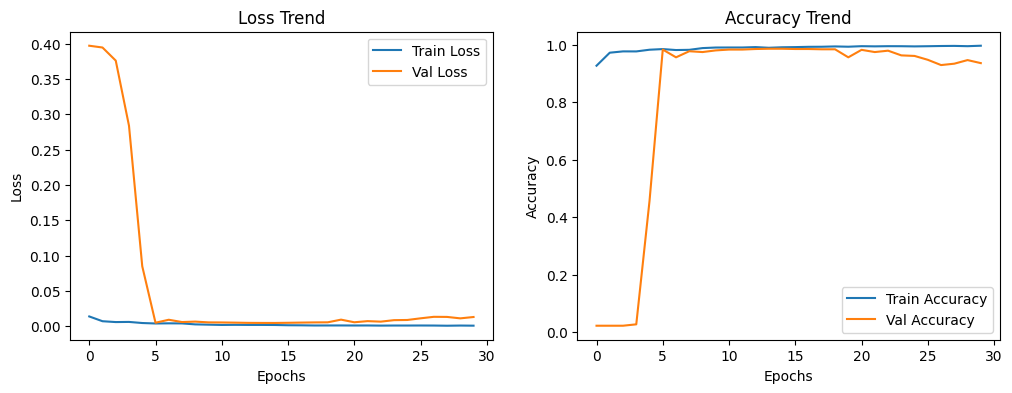


Best Decision Threshold: 0.792
F1 Score: 0.8293


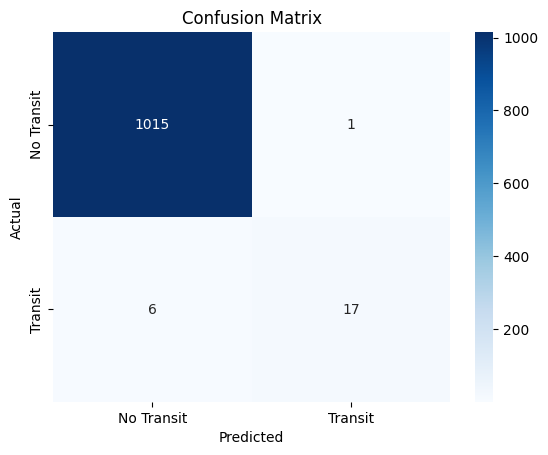

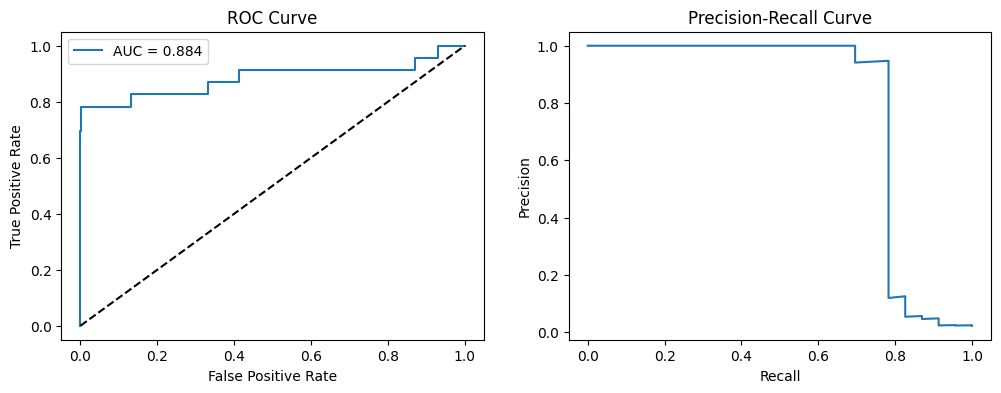

Classification Report:
               precision    recall  f1-score   support

  No Transit       0.99      1.00      1.00      1016
     Transit       0.94      0.74      0.83        23

    accuracy                           0.99      1039
   macro avg       0.97      0.87      0.91      1039
weighted avg       0.99      0.99      0.99      1039

Model saved successfully!


In [68]:
if __name__ == "__main__":
    main()

Loading saved dataset...


/Users/Arnav/Documents/EXXA-Evaluation-Test/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 1996, 128)      │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1996, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 998, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 998, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 994, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 994, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 497, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 497, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 497, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 528,385 (2.02 MB)

 Trainable params: 527,617 (2.01 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 30s 391ms/step - accuracy: 0.9601 - auc: 0.7364 - loss: 0.0169 - val_accuracy: 0.0298 - val_auc: 0.7512 - val_loss: 0.0899 - learning_rate: 1.0000e-04
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 333ms/step - accuracy: 0.9878 - auc: 0.8877 - loss: 0.0038 - val_accuracy: 0.0298 - val_auc: 0.7096 - val_loss: 0.1400 - learning_rate: 1.0000e-04
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 344ms/step - accuracy: 0.9874 - auc: 0.8792 - loss: 0.0037 - val_accuracy: 0.0298 - val_auc: 0.6370 - val_loss: 0.1573 - learning_rate: 1.0000e-04
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.9873 - auc: 0.9213 - loss: 0.0032
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 355ms/step - accuracy: 0.9873 - auc: 0.9209 - loss: 0.0032 - val_accuracy: 0.0298 - val_auc: 0.6127 - val_loss: 0.1615 - learning_rate: 1.0000e-04
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 332ms/step - accuracy: 0.9906 - auc: 

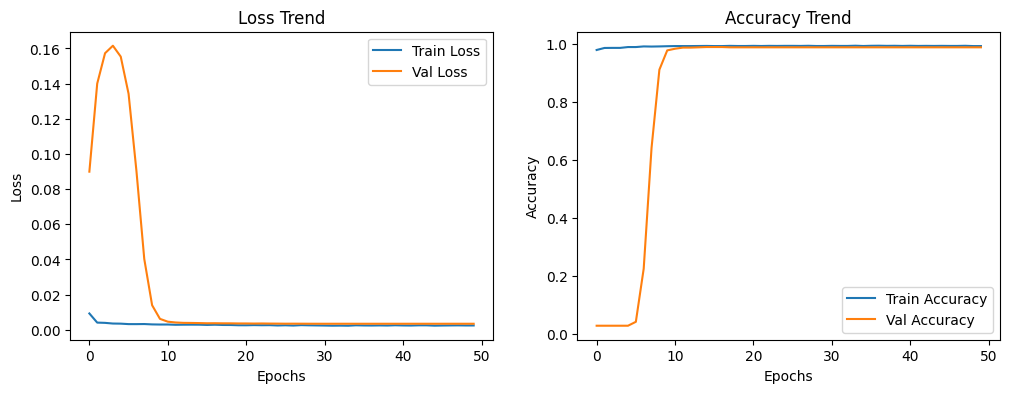


Best Decision Threshold: 0.567
F1 Score: 0.8000


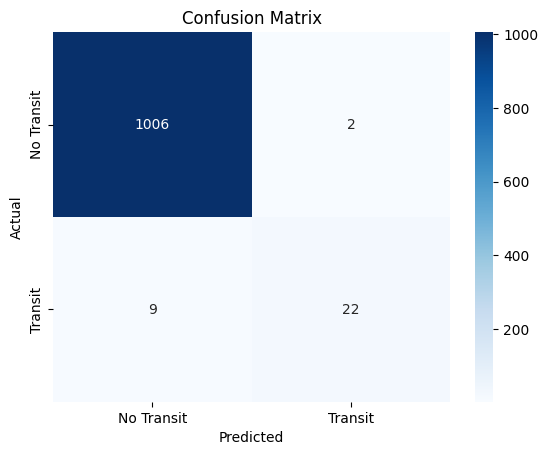

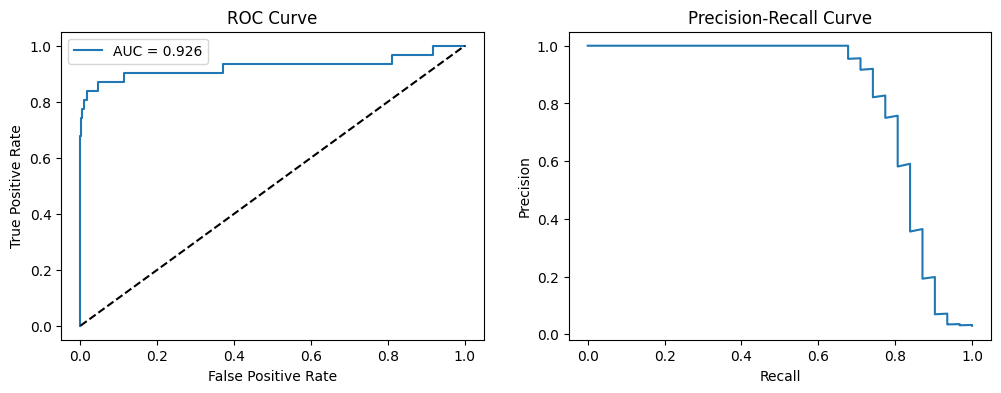

Classification Report:
               precision    recall  f1-score   support

  No Transit       0.99      1.00      0.99      1008
     Transit       0.92      0.71      0.80        31

    accuracy                           0.99      1039
   macro avg       0.95      0.85      0.90      1039
weighted avg       0.99      0.99      0.99      1039

Model saved successfully!


In [54]:
if __name__ == "__main__":
    main()

Loading saved dataset...


/Users/Arnav/Documents/EXXA-Evaluation-Test/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 1996, 128)      │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1996, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 998, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 998, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 994, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 994, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 497, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 497, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 497, 128)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 528,385 (2.02 MB)

 Trainable params: 527,617 (2.01 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 356ms/step - accuracy: 0.8664 - auc: 0.7225 - loss: 0.6340 - val_accuracy: 0.0298 - val_auc: 0.7606 - val_loss: 0.7222 - learning_rate: 1.0000e-05
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 336ms/step - accuracy: 0.9856 - auc: 0.8245 - loss: 0.4863 - val_accuracy: 0.0298 - val_auc: 0.7320 - val_loss: 0.8041 - learning_rate: 1.0000e-05
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 22s 339ms/step - accuracy: 0.9872 - auc: 0.8571 - loss: 0.3105 - val_accuracy: 0.0298 - val_auc: 0.7135 - val_loss: 0.9044 - learning_rate: 1.0000e-05
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9882 - auc: 0.8811 - loss: 0.1646
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 352ms/step - accuracy: 0.9882 - auc: 0.8808 - loss: 0.1643 - val_accuracy: 0.0298 - val_auc: 0.7083 - val_loss: 0.9570 - learning_rate: 1.0000e-05
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 23s 358ms/step - accuracy: 0.9883 - auc: 

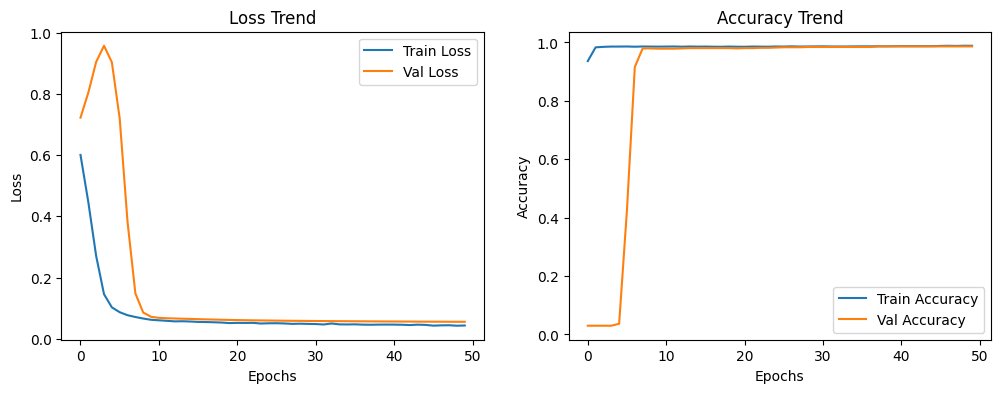


Best Decision Threshold: 0.405
F1 Score: 0.7368


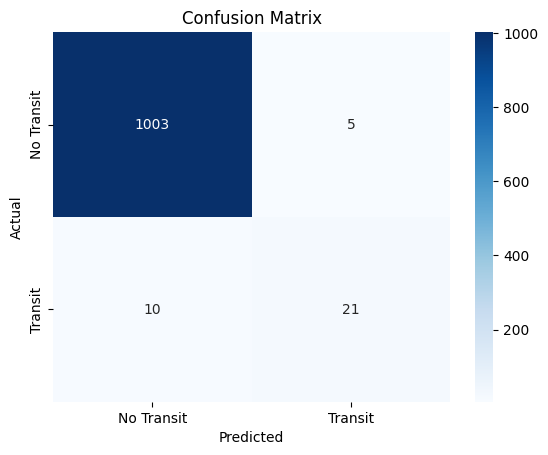

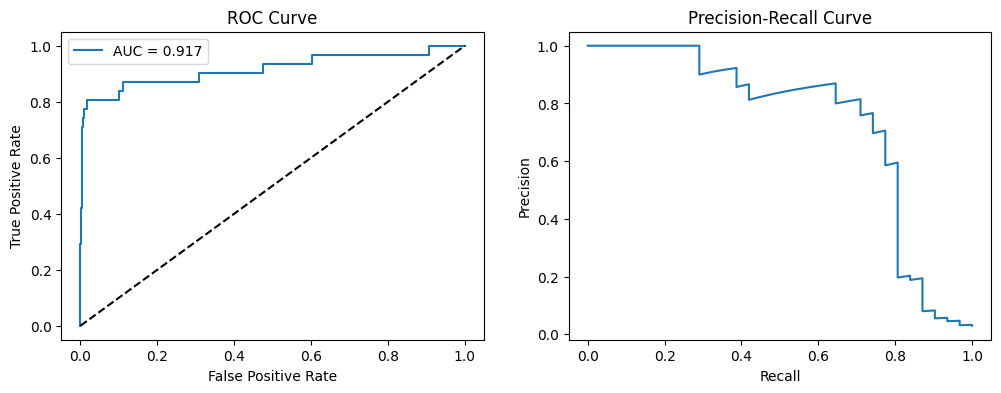

Classification Report:
               precision    recall  f1-score   support

  No Transit       0.99      1.00      0.99      1008
     Transit       0.81      0.68      0.74        31

    accuracy                           0.99      1039
   macro avg       0.90      0.84      0.86      1039
weighted avg       0.98      0.99      0.98      1039

Model saved successfully!


In [40]:
if __name__ == "__main__":
    main()